In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
sns.set()


In [39]:
dick = pd.read_pickle('country_data.pkl')
world_df = pd.read_pickle('global_data.pkl')


 [-----------------100%-----------------] 1000000 of 1000000 complete in 1254.9 sec           M_mu_post   M_sigma_post      F_mu_post   F_sigma_post  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean        0.281451       0.964027       1.180180       0.051461   
std         0.167294       0.033065       0.162576       0.028852   
min         0.100006       0.689110       1.000010       0.000048   
25%         0.155415       0.948890       1.053696       0.026583   
50%         0.231258       0.973568       1.128393       0.052151   
75%         0.357033       0.988711       1.259534       0.076629   
max         0.999945       0.999999       1.928563       0.100000   

              M_post         F_post  
count  250000.000000  250000.000000  
mean        0.010727       3.247259  
std         0.001711       0.603073  
min         0.005944       2.250711  
25%         0.009703       2.824357  
50%         0.011052       3.060425  
75%         0.011976       3.

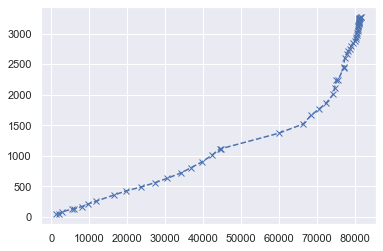

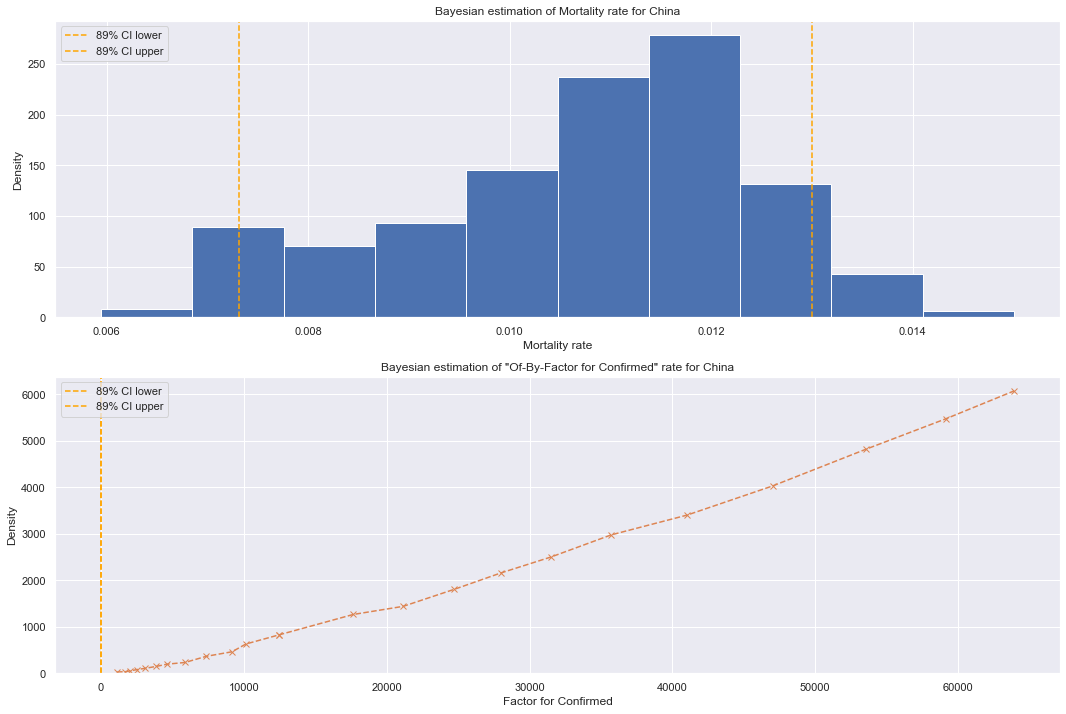

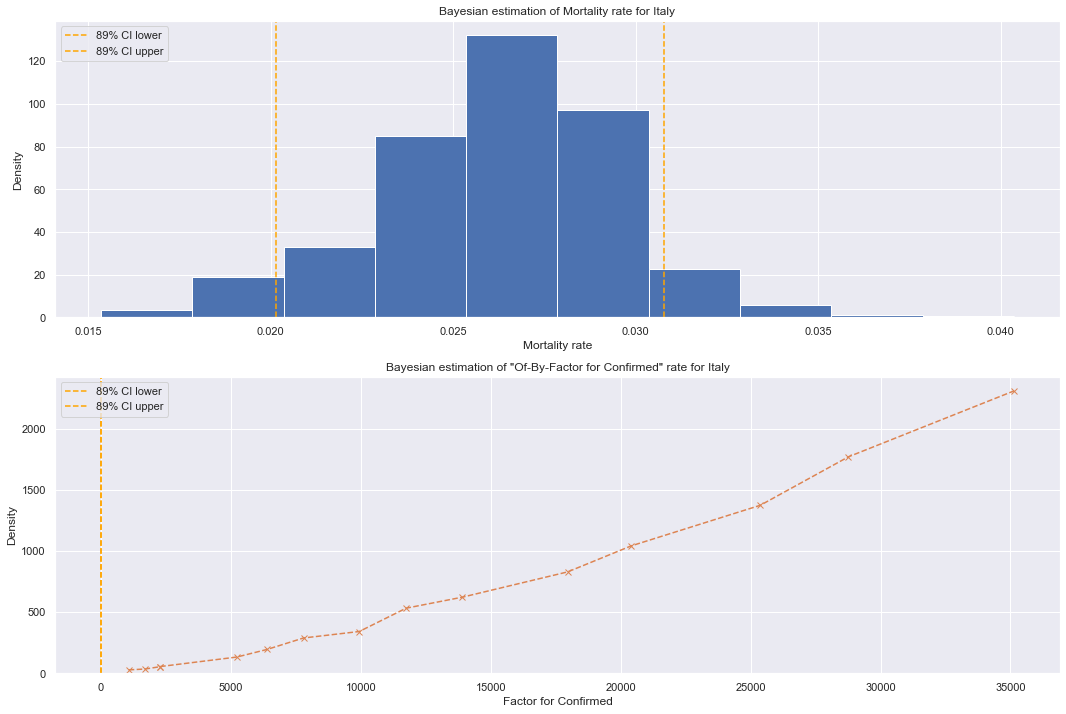

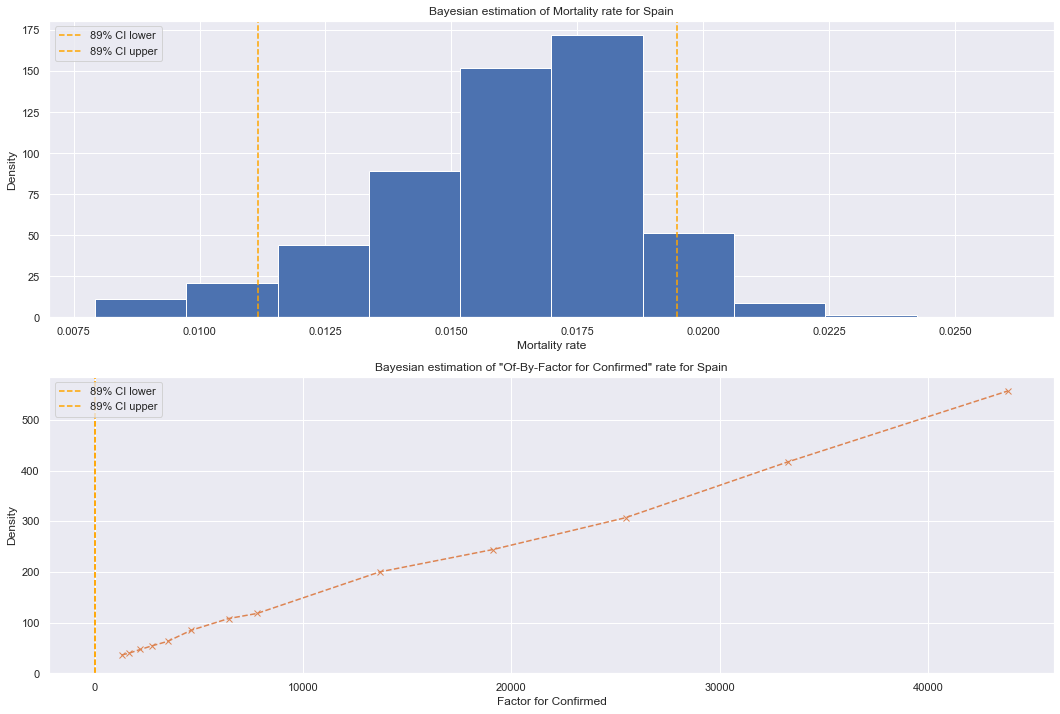

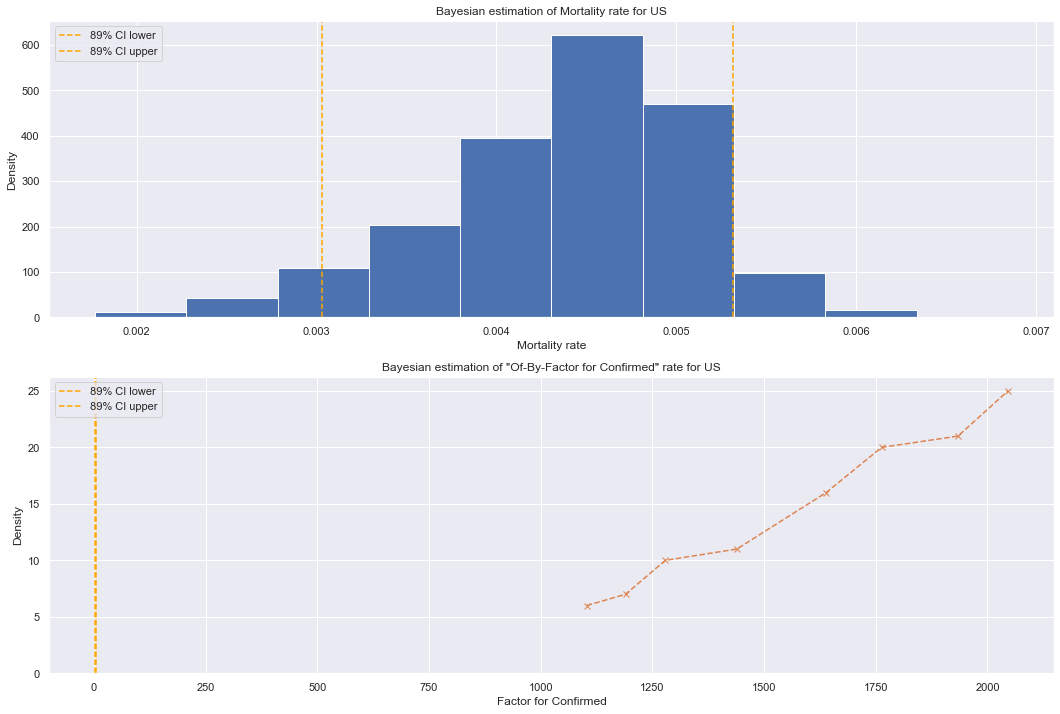

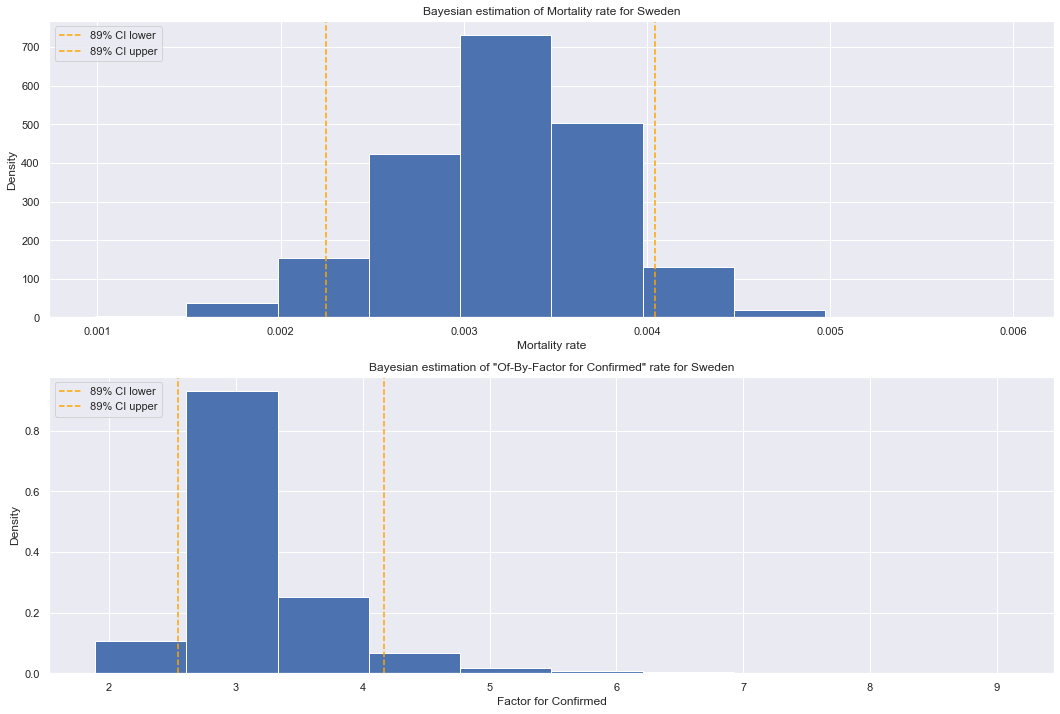

In [40]:


def process_country(country):
    df = dick[country]
    
    mask = df['confirmed'] > 1000
    df = df[mask]
    mask = df['deceased'] > 5
    df = df[mask]
    
    confirmed_mean = df['confirmed'].mean()
    confirmed_std = df['confirmed'].std()
    dead_mean = df['deceased'].mean()
    dead_std = df['deceased'].std()
    
    #confirmed_s = (df['confirmed'] - confirmed_mean) / confirmed_std
    #dead_s = (df['deceased'] - dead_mean) / dead_std
    
    confirmed_s = df['confirmed']
    dead_s = df['deceased']
    
    plt.plot(confirmed_s,dead_s,'x--')
    
    M_mu = pm.Uniform('M_mu',lower=0.1,upper=1)
    M_sigma = pm.Uniform('M_sigma',lower=0,upper=1)
    F_mu = pm.Uniform('F_mu',lower=1,upper=5)
    F_sigma = pm.Uniform('F_sigma',lower=0,upper=0.1)
    
    M = pm.Lognormal('M',mu=M_mu,tau=1/M_sigma ** 2)
    F = pm.Lognormal('F',mu=F_mu,tau=1/F_sigma ** 2)
    
    
    @pm.deterministic()
    def gen_dead(confirmed_s=confirmed_s,F=F,M=M):
        return confirmed_s * F * M
    
    obs = pm.Poisson('obs',mu=gen_dead,observed=True,value=dead_s)
    
    model = pm.Model([M_mu,M_sigma,F_mu,F_sigma,M,F,gen_dead,obs])
    map_ = pm.MAP(model)
    #map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(1000000,500000,2)
    
    M_mu_post = mcmc.trace('M_mu')[:]
    M_sigma_post = mcmc.trace('M_sigma')[:]
    F_mu_post = mcmc.trace('F_mu')[:]
    F_sigma_post = mcmc.trace('F_sigma')[:]
    M_post = mcmc.trace('M')[:]
    F_post = mcmc.trace('F')[:]
    
    result = pd.DataFrame({'M_mu_post' : M_mu_post,
                          'M_sigma_post' : M_sigma_post,
                          'F_mu_post' : F_mu_post,
                          'F_sigma_post' : F_sigma_post,
                          'M_post' : M_post,
                          'F_post' : F_post})
    
    return result

def plot(country_name,result):
    
    M_low,M_high = np.percentile(result.M_post,[5,94])
    F_low,F_high = np.percentile(result.F_post,[5,94])
    
    plt.figure(figsize=(18,12))
    plt.subplot(211)
    plt.title('Bayesian estimation of Mortality rate for {}'.format(country_name))
    plt.xlabel('Mortality rate')
    plt.ylabel('Density')
    plt.axvline(M_low,color='orange',ls='dashed',label='89% CI lower')
    plt.axvline(M_high,color='orange',ls='dashed',label='89% CI upper')
    plt.legend(loc='upper left')
    plt.hist(result.M_post,density=True,bins=10)

    plt.subplot(212)
    plt.title('Bayesian estimation of "Of-By-Factor for Confirmed" rate for {}'.format(country_name))
    plt.xlabel('Factor for Confirmed')
    plt.ylabel('Density')
    plt.axvline(F_low,color='orange',ls='dashed',label='89% CI lower')
    plt.axvline(F_high,color='orange',ls='dashed',label='89% CI upper')
    plt.legend(loc='upper left')
    plt.hist(result.F_post,density=True,bins=10)

    plt.savefig('Bayesian_estimate_mortality_and_factor_{}_.jpg'.format(country_name),format='jpg')


country_list = ['China','Italy','Spain','US','Sweden']

for c in country_list:
    result = process_country(c)
    plot(c,result)
    print (result.describe())



 [-----------------100%-----------------] 1000000 of 1000000 complete in 1302.5 sec

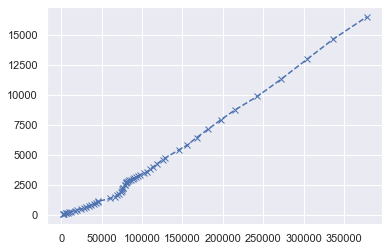

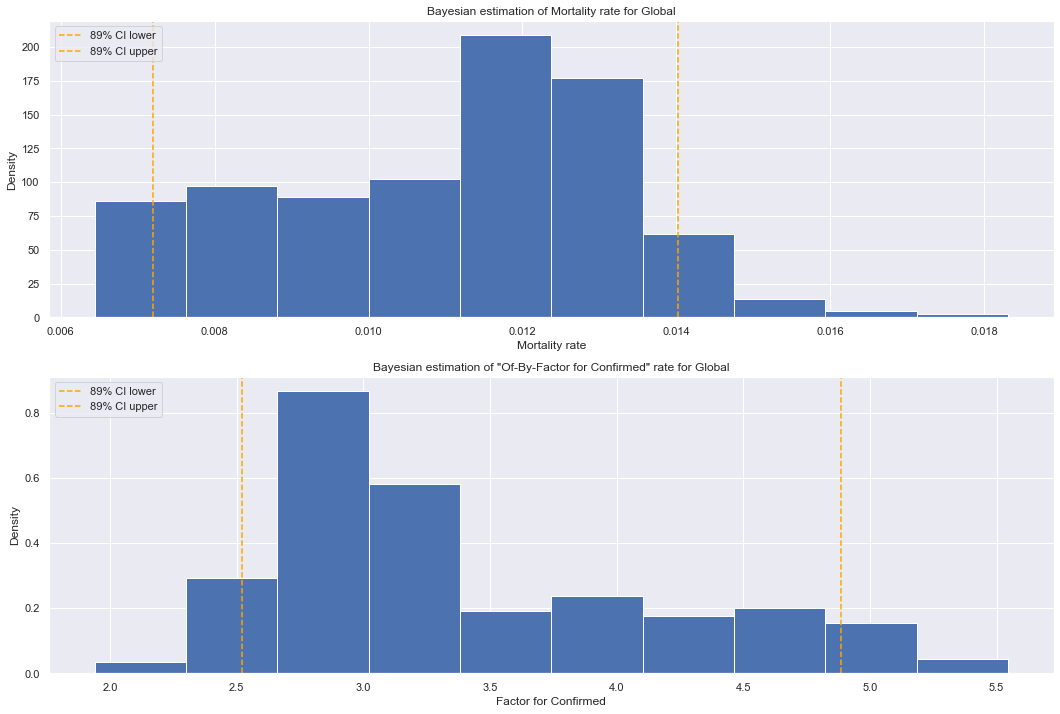

In [41]:
def process_world(df):
    
    mask = df['confirmed'] > 1000
    df = df[mask]
    mask = df['dead'] > 5
    df = df[mask]
    
    confirmed_mean = df['confirmed'].mean()
    confirmed_std = df['confirmed'].std()
    dead_mean = df['dead'].mean()
    dead_std = df['dead'].std()
    
    #confirmed_s = (df['confirmed'] - confirmed_mean) / confirmed_std
    #dead_s = (df['deceased'] - dead_mean) / dead_std
    
    confirmed_s = df['confirmed']
    dead_s = df['dead']
    
    plt.plot(confirmed_s,dead_s,'x--')
    
    M_mu = pm.Uniform('M_mu',lower=0.1,upper=1)
    M_sigma = pm.Uniform('M_sigma',lower=0,upper=1)
    F_mu = pm.Uniform('F_mu',lower=1,upper=5)
    F_sigma = pm.Uniform('F_sigma',lower=0,upper=0.1)
    
    M = pm.Lognormal('M',mu=M_mu,tau=1/M_sigma ** 2)
    F = pm.Lognormal('F',mu=F_mu,tau=1/F_sigma ** 2)
    
    
    @pm.deterministic()
    def gen_dead(confirmed_s=confirmed_s,F=F,M=M):
        return confirmed_s * F * M
    
    obs = pm.Poisson('obs',mu=gen_dead,observed=True,value=dead_s)
    
    model = pm.Model([M_mu,M_sigma,F_mu,F_sigma,M,F,gen_dead,obs])
    map_ = pm.MAP(model)
    #map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(1000000,500000,2)
    
    M_mu_post = mcmc.trace('M_mu')[:]
    M_sigma_post = mcmc.trace('M_sigma')[:]
    F_mu_post = mcmc.trace('F_mu')[:]
    F_sigma_post = mcmc.trace('F_sigma')[:]
    M_post = mcmc.trace('M')[:]
    F_post = mcmc.trace('F')[:]
    
    result = pd.DataFrame({'M_mu_post' : M_mu_post,
                          'M_sigma_post' : M_sigma_post,
                          'F_mu_post' : F_mu_post,
                          'F_sigma_post' : F_sigma_post,
                          'M_post' : M_post,
                          'F_post' : F_post})
    
    return result

def plot_world(result,title):
    
    M_low,M_high = np.percentile(result.M_post,[5,94])
    F_low,F_high = np.percentile(result.F_post,[5,94])
    
    plt.figure(figsize=(18,12))
    plt.subplot(211)
    plt.title('Bayesian estimation of Mortality rate for {}'.format(title))
    plt.xlabel('Mortality rate')
    plt.ylabel('Density')
    plt.axvline(M_low,color='orange',ls='dashed',label='89% CI lower')
    plt.axvline(M_high,color='orange',ls='dashed',label='89% CI upper')
    plt.legend(loc='upper left')
    plt.hist(result.M_post,density=True,bins=10)

    plt.subplot(212)
    plt.title('Bayesian estimation of "Of-By-Factor for Confirmed" rate for {}'.format(title))
    plt.xlabel('Factor for Confirmed')
    plt.ylabel('Density')
    plt.axvline(F_low,color='orange',ls='dashed',label='89% CI lower')
    plt.axvline(F_high,color='orange',ls='dashed',label='89% CI upper')
    plt.legend(loc='upper left')
    plt.hist(result.F_post,density=True,bins=10)

    plt.savefig('Bayesian_estimate_mortality_and_factor_{}.jpg'.format(title),format='jpg')

world_df = pd.read_pickle('global_data.pkl')

result_world = process_world(world_df)
plot_world(result_world,'Global')